In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
import segmentation_models_pytorch as smp
import PIL
import os
import numpy as np
import albumentations as A
from albumentations.augmentations.blur import transforms as a_t
import matplotlib.pyplot as plt

c:\ProgramData\Miniconda3\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.__version__

'2.0.1'

In [3]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, imgs_path, targets_path, transform=None, target_transform=None, All_transform=None, Image_transform=None):
        self.data_paths = []
        self.label_paths = []
        self.All_transform = All_transform
        self.Image_transform = Image_transform
        if target_transform:
            self.target_transform = target_transform
        else:
            self.target_transform = transforms.ToTensor()
        
        if transform:
            self.transform = transform
        else:
            self.transform = transforms.ToTensor()

        for img_name in sorted(os.listdir(imgs_path)):
            full_path = os.path.join(imgs_path, img_name)
            self.data_paths.append(full_path)

        for target_name in sorted(os.listdir(targets_path)):
            full_path = os.path.join(targets_path, target_name)
            self.label_paths.append(full_path)


    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        img = PIL.Image.open(self.data_paths[idx])
        target = PIL.Image.open(self.label_paths[idx]).convert('L')
        img , target = np.array(img), np.array(target)
        if self.All_transform:
            augmented = self.All_transform(image=img, mask=target)
            img , target = augmented['image'], augmented['mask']

        if self.Image_transform:    
            img = self.Image_transform(image=img)['image']
            
        img , target = PIL.Image.fromarray(img), PIL.Image.fromarray(target)
        img = self.transform(img)
        target = self.target_transform(target)
        
        return img, target


In [4]:
input_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])
def mask_transform(mask):
    # resize and crop the mask
    mask = transforms.Resize(224)(mask)
    mask = transforms.CenterCrop(224)(mask)
    # convert the mask to tensor
    mask = torch.as_tensor(np.asarray(mask, np.float32))
    # map the void category to 255
    # mask[mask == 21] = 255
    return mask



All_transform = A.Compose([
    A.OneOf([
        A.RandomCrop(width=256, height=256),
        A.HorizontalFlip(p=0.5),
        # A.RandomBrightnessContrast(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Transpose(p=0.5)
    ], p=1),

    # A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    # A.GridDistortion(p=0.5),
    # A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.5)
])

Image_transform = A.Compose([
    a_t.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=0.5),
    a_t.GlassBlur (sigma=0.7, max_delta=4, iterations=2, always_apply=False, mode='fast', p=0.5),
    A.augmentations.transforms.RandomBrightnessContrast (brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=0.5),
    A.augmentations.transforms.RandomFog (fog_coef_lower=0.3, fog_coef_upper=1, alpha_coef=0.08, always_apply=False, p=0.5),
    A.augmentations.transforms.RandomGamma (gamma_limit=(80, 120), eps=None, always_apply=False, p=0.5),
    # A.augmentations.transforms.RandomGravel (gravel_roi=(0.1, 0.4, 0.9, 0.9), number_of_patches=2, always_apply=False, p=0.5),
    A.augmentations.transforms.RandomRain (slant_lower=-10, slant_upper=10, drop_length=20, drop_width=1, drop_color=(200, 200, 200), blur_value=7, brightness_coefficient=0.7, rain_type=None, always_apply=False, p=0.5),
    A.augmentations.transforms.RandomShadow (shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, shadow_dimension=5, always_apply=False, p=0.5),
    A.augmentations.transforms.RandomSnow (snow_point_lower=0.1, snow_point_upper=0.3, brightness_coeff=2.5, always_apply=False, p=0.5),
    A.augmentations.transforms.RandomToneCurve (scale=0.1, always_apply=False, p=0.5),
    A.augmentations.transforms.RingingOvershoot (blur_limit=(7, 15), cutoff=(0.7853981633974483, 1.5707963267948966), always_apply=False, p=0.5),
])




In [5]:
train_target_path='C:/Users/Mohammad/Documents/Projects/LPCV/LPCVC_Train_Updated/LPCVC_Train_Updated/LPCVC_Train_Updated/GT_Updated/train/'
train_image_path='C:/Users/Mohammad/Documents/Projects/LPCV/LPCVC_Train_Updated/LPCVC_Train_Updated/LPCVC_Train_Updated/IMG/train/'

val_target_path='C:/Users/Mohammad/Documents/Projects/LPCV/LPCVC_Val/LPCVC_Val/GT/val/'
val_image_path='C:/Users/Mohammad/Documents/Projects/LPCV/LPCVC_Val/LPCVC_Val/IMG/val/'

train_dataset = MyDataset(imgs_path=train_image_path, targets_path=train_target_path, transform=input_transform, target_transform=mask_transform, All_transform=All_transform, Image_transform=Image_transform)
val_dataset = MyDataset(imgs_path=val_image_path, targets_path=val_target_path, transform=input_transform, target_transform=mask_transform, All_transform=None, Image_transform=None)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True)

In [6]:
train_dataset.__len__(), val_dataset.__len__()

(1021, 100)

In [7]:
for images, masks in train_loader:
    # Do something with the images and masks
    print(images.shape, masks.shape, len(images))
    break

torch.Size([16, 3, 224, 224]) torch.Size([16, 224, 224]) 16


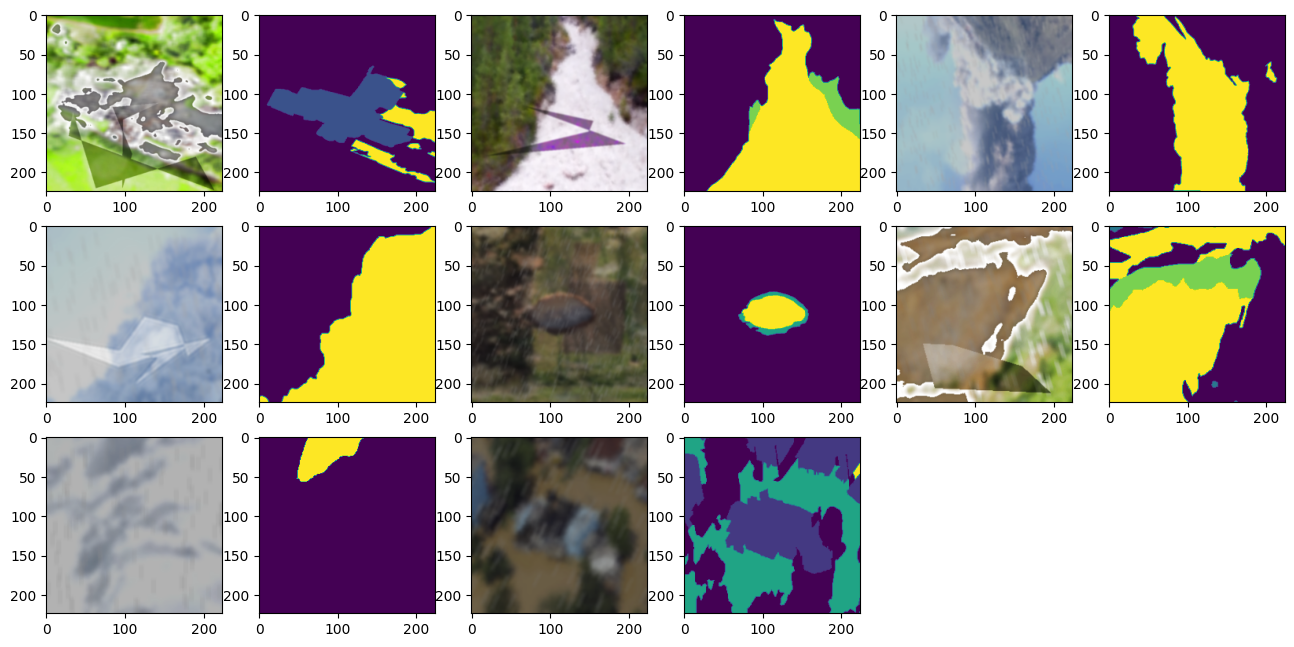

In [8]:
fig = plt.figure(figsize=(16, 16))
for i in range(1,len(images)+1,2):
    fig.add_subplot(6, 6, i)
    plt.imshow(torch.permute(images[i], (1,2,0)))
    # plt.imshow(images[i])
    fig.add_subplot(6, 6, i+1)
    plt.imshow(masks[i])

plt.show()

In [9]:
device=torch.device('cuda')
# device=torch.device('cpu')

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(MyCrossEntropyLoss, self).__init__()

    def forward(self, outputs, targets):
        outputs = outputs.view(-1, 14)
        targets = targets.view(-1)
        log_probs = F.log_softmax(outputs, dim=1)
        log_probs = log_probs.type(torch.LongTensor)
        targets = targets.type(torch.LongTensor)
        loss = F.nll_loss(log_probs, targets)
        
        return loss


In [11]:
torch.cuda.empty_cache()

In [11]:
model = smp.DeepLabV3Plus(
    encoder_name="timm-mobilenetv3_small_minimal_100",
    encoder_weights="imagenet",
    in_channels=3,
    classes=14,
)
model = model.to(device)
# criterion = MyCrossEntropyLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(100):
    for iteration , (images, labels) in enumerate(train_loader):
        labels = labels.type(torch.LongTensor) 
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if iteration % 16 == 0 :
            n_correct = 0
            outputs = model(images)
            loss = criterion(outputs, labels)
            # probs, indexs = torch.max(outputs.data, 1)
            # n_correct = (indexs == labels).sum().item()
            # acc = n_correct/len(labels) * 100
            print(f"Epoch: {epoch}, Iter: {iteration}, Loss: {loss}") #, Accuracy: {acc} %")
    with torch.no_grad():
        n_correct = 0 
        loss = 0
        for iteration , (images, labels) in enumerate(val_loader):
            labels = labels.type(torch.LongTensor) 
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels)
            # probs, indexs = torch.max(outputs.data, 1)
            # n_correct += (indexs == labels).sum().item()
        
        # acc = n_correct/(len(val_loader) * val_loader.batch_size) * 100
        final_loss = loss/len(val_loader)
        print(f"Epoch: {epoch}, Loss Validation: {final_loss}")#, Accuracy Test: {acc} %")
    if epoch % 5 == 0 and epoch !=0:
        torch.save(model.state_dict, f"./DeepLabV3Plus_timm-mobilenetv3_small_minimal_100_state_dict_Epoch_{epoch}.pt")
        torch.save(model, f"./DeepLabV3Plus_timm-mobilenetv3_small_minimal_100_model_Epoch_{epoch}.pt")

Epoch: 0, Iter: 0, Loss: 2.1486847400665283
Epoch: 0, Iter: 16, Loss: 1.5594379901885986


In [ ]:
torch.save(model.state_dict, "./DeepLabV3Plus_timm-mobilenetv3_small_minimal_100_state_dict.pt")
torch.save(model, "./DeepLabV3Plus_timm-mobilenetv3_small_minimal_100_model.pt")

In [13]:
model = torch.load('./DeepLabV3Plus_timm-efficientnet-b6_model_Epoch_225.pt')

In [14]:
for images, masks in val_loader:
    # Do something with the images and masks
    print(images.shape, masks.shape, len(images))
    break

torch.Size([16, 3, 224, 224]) torch.Size([16, 224, 224]) 16


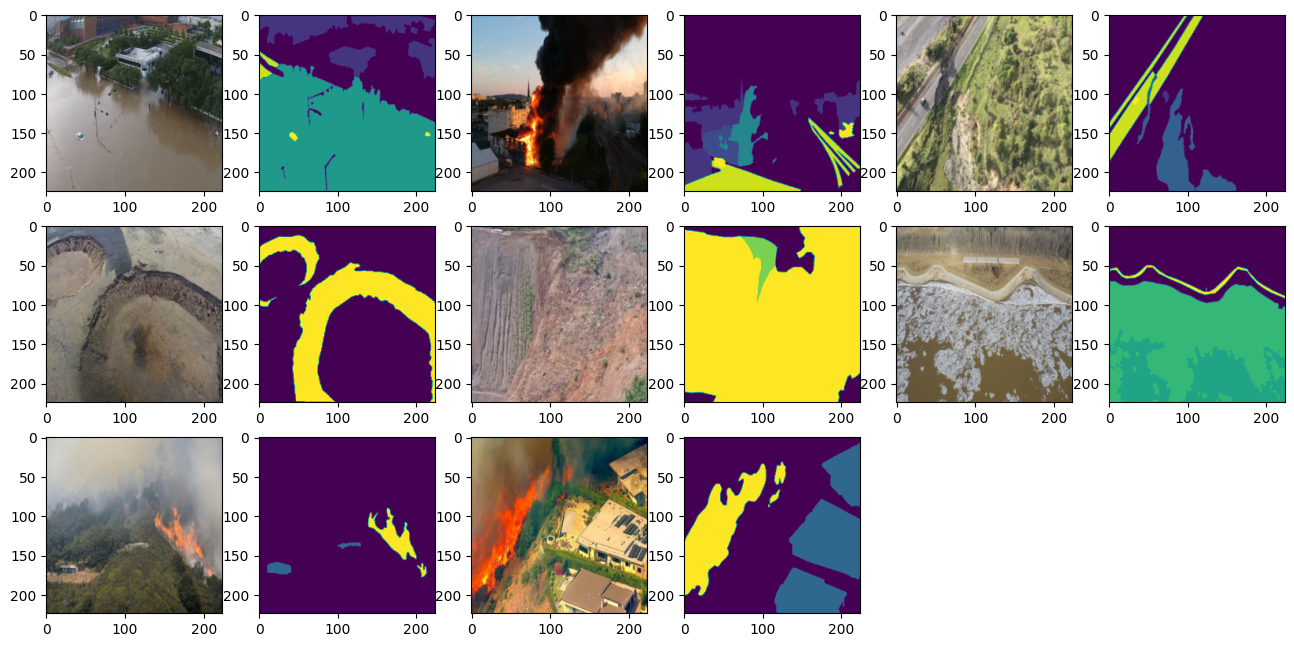

In [15]:
fig = plt.figure(figsize=(16, 16))
for i in range(1,len(images)+1,2):
    fig.add_subplot(6, 6, i)
    plt.imshow(torch.permute(images[i], (1,2,0)))
    # plt.imshow(images[i])
    fig.add_subplot(6, 6, i+1)
    plt.imshow(masks[i])

plt.show()

In [16]:
gpu_img = images.to(device)
gpu_out = model(gpu_img)
out = gpu_out.cpu()
print(out.shape)

torch.Size([16, 14, 224, 224])


In [ ]:
out = torch.argmax(out, dim=1)
print(out.shape)

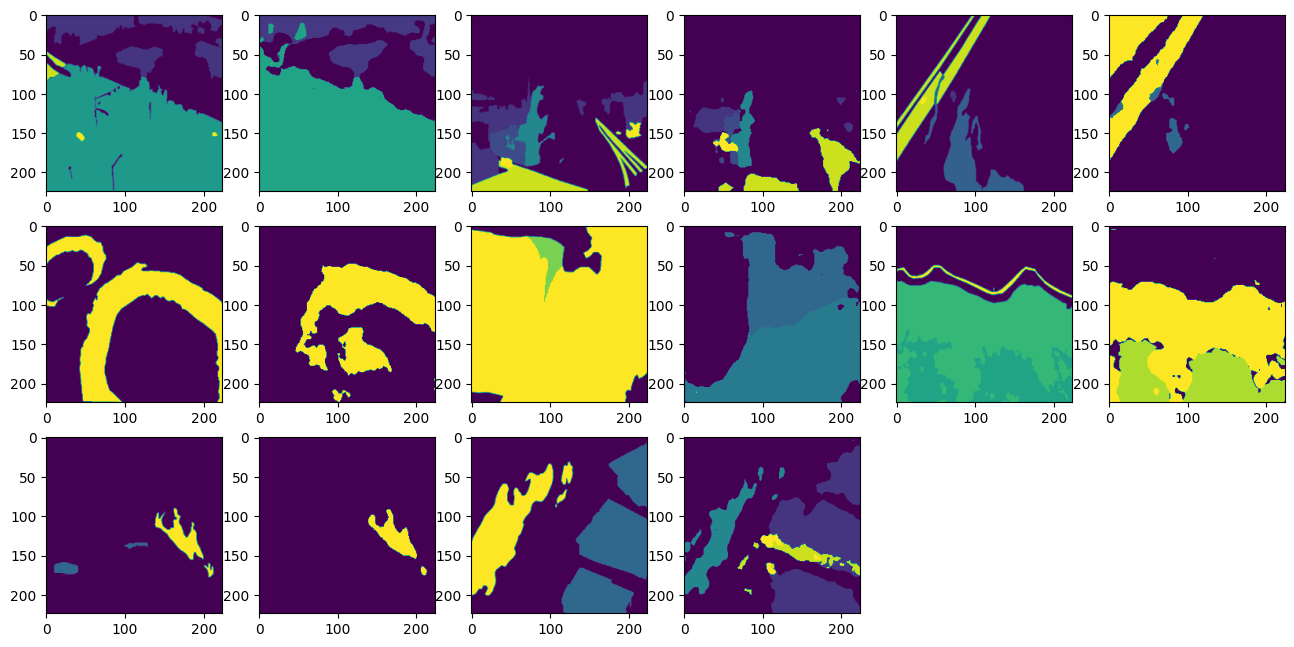

In [18]:
fig = plt.figure(figsize=(16, 16))
for i in range(1,len(images)+1,2):
    fig.add_subplot(6, 6, i)
    # plt.imshow(torch.permute(images[i], (1,2,0)))
    # fig.add_subplot(6, 6, i+1)
    plt.imshow(masks[i]*15)
    fig.add_subplot(6, 6, i+1)
    plt.imshow(out[i]*15)

plt.show()